# PLAN

- [x] Acquisition
    - [x] Select what list of repos to scrape.
    - [x] Get requests form the site.
    - [x] Save responses to csv.
- [ ] Preparation
    - [x] Prepare the data for analysis.
- [ ] Exploration
    - [ ] Answer the following prompts:
        - [ ] What are the most common words in READMEs?
        - [ ] What does the distribution of IDFs look like for the most common words?
        - [ ] Does the length of the README vary by language?
        - [ ] Do different languages use a different number of unique words?
- [ ] Modeling
    - [ ] Transform the data for machine learning; use language to predict.
    - [ ] Fit several models using different text repressentations.
    - [ ] Build a function that will take in the text of a README file, and makes a prediction of language.
- [ ] Delivery
    - [ ] Github repo
        - [x] This notebook.
        - [ ] Documentation within the notebook.
        - [ ] README file in the repo.
        - [ ] Python scripts if applicable.
    - [ ] Google Slides
        - [ ] 1-2 slides only summarizing analysis.
        - [ ] Visualizations are labeled.
        - [ ] Geared for the general audience.
        - [ ] Share link @ readme file and/or classroom.

# ENVIRONMENT

In [1]:
# disable warnings
import warnings
warnings.filterwarnings("ignore")

import unicodedata
import re
from requests import get
import json
# import spacy
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import pandas as pd
import time
import csv
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

#Global variables holding all of our language names and additional stopwords
LANGUAGES = ['JavaScript', 'Rust', 'C++', 'Python', 'Dart', 'Java', 'Go', 'CSS',
            'PHP', 'TypeScript', 'Ruby', 'HTML', 'C', 'Vue', 'C#', 'Shell',
            'Clojure', 'Objective-C', 'Swift', 'Jupyter Notebook',
            'Vim script', 'Assembly', 'Kotlin', 'Dockerfile', 'TeX', 'javascript', 'rust', 'c++', 'python', 'dart',
             'java', 'go', 'css', 'php', 'typescript', 'ruby', 'html', 'c', 'vue', 'c#', 'shell', 'clojure', 
             'objective-c', 'swift', 'jupyter notebook', 'vim script', 'assembly', 'kotlin', 'dockerfile', 'tex']

BASEURL = 'https://github.com/search?p=1&q=stars%3A%3E0&s=stars&type=Repositories'
HEADERS = {'User-Agent': 'Definitely not Sentient Attack Helicoptor'}

# ACQUIRE

First thing that needs to happen is to get the links from the most starred github repositories.  The most complicated part here was identifying the section that had the actual urls.

The `get_url_list` function does the following:
* get a response from the BASEURL
* set number of pages to scrape and loop through all of them
* find the list of all the repos on the page
* from that list find the individual list item repos
* do a check to see if there is a language associated with the repo
* * if no language, skip
* loop through individual repo sections and grab the url
* print out a list of the total valid urls scraped
* save the resulting list of urls to a csv
* return the urls

In [2]:
def get_url_list(page):
    urls = []
    response = get(BASEURL, headers=HEADERS)
    soup = BeautifulSoup(response.content)
    max_page = page + 1
    for i in range(1,max_page):
        url = 'https://github.com/search?p=' + str(i) + '&q=stars%3A%3E0&s=stars&type=Repositories'
        print(f'traversing url: {url}')
        response = get(url, headers=HEADERS)
        soup = BeautifulSoup(response.text)
        list_of_repos = soup.find('ul', class_='repo-list')
        repository = list_of_repos.find_all('li', class_='repo-list-item')
        for h in repository:
            if h.find(attrs={'itemprop':'programmingLanguage'}):
                a = h.find('a')
                urls.append(a.attrs['href'])
        time.sleep(3)
    print(f'Scraped a total of {len(urls)} github urls.')
    urls = ['https://github.com' + url for url in urls]
    with open('github_urls.csv', 'w') as f:
        ghub_urls = csv.writer(f, delimiter=',')
        ghub_urls.writerow(urls)
    return urls


Now that we have the list of urls from `get_url_list`, we need to do the following:
* visit each of the urls
* find the main body of the `README.md`
* * if there is no body in the `README.md` then skip it
* grab the readme info
* find the prominent language and grab that as well
* do this for all the urls in the list from the previous function

In [3]:
def grab_readmes_and_languages(urls):
    readmes = []
    languages = []
    for url in urls:
        response = get(url)
        soup = BeautifulSoup(response.content, 'html.parser')
        if soup.find('div', class_='Box-body') == None:
            continue
        else:
            single_readme = soup.find('div', class_='Box-body').text
        if soup.find('span', class_='lang') == None:
            continue
        else:
            repo_language = soup.find('span', class_='lang').text
        languages.append(repo_language)
        readmes.append(single_readme)
    df = pd.DataFrame({'readme':readmes, 'language':languages})
    return df

Now that we have a big bunch of words and languages in a dataframe, we need to do some cleanup.  These functions will do the following:
* lowercase all the text
* normalize the language into english-only
* only keep words that start with letters, numbers, or whitespace
* strip any whitespace at the start or the end of a word
* replace any newlines with a space
* tokenize the words
* either stem or lemmatize the words
* remove all standard stopwords as well as the languages and any additional stopwords that were found during exploration

In [4]:
def basic_clean(string):
    """Will lowercase, normalize, and remove anything that isn't a letter, number,
    whitespace or single quote and return it."""
    clean_string = string.lower()
    clean_string = unicodedata.normalize('NFKD', clean_string).\
                    encode('ascii', 'ignore').\
                    decode('utf-8', 'ignore')
    clean_string = re.sub(r'[^a-z0-9\s]', '', clean_string)
    clean_string = clean_string.strip()
    clean_string = re.sub(r'\s+', ' ', clean_string)
    return clean_string

def tokenize(string, string_or_list='string'):
    """nltk.tokenize.ToktokTokenizer"""
    tokenizer = nltk.tokenize.ToktokTokenizer()
    if string_or_list == 'string':
        return tokenizer.tokenize(string, return_str=True)
    if string_or_list == 'list':
        return tokenizer.tokenize(string)
    
def stem(string, string_or_list='string'):
    """Returns the stems."""
    ps = nltk.porter.PorterStemmer()
    stems = [ps.stem(word) for word in string.split()]
    stemmed_string = ' '.join(stems)
    if string_or_list == 'list':
        return stems
    if string_or_list == 'string':
        return stemmed_string
    
def lemmatize(string, string_or_list='string'):
    """Returns the lemmatized text."""
    wnl = nltk.stem.WordNetLemmatizer()
    lemmas = [wnl.lemmatize(word) for word in string.split()]
    lemmatized_string = ' '.join(lemmas)
    if string_or_list == 'string':
        return lemmatized_string
    if string_or_list == 'list':
        return lemmas
    
def remove_stopwords(string, string_or_list='string', extra_words=None, exclude_words=None):
    """Removes the stopwords from the text then returns it. Able to add or remove stopwords."""
    stopword_list = stopwords.words('english') #+ LANGUAGES
    if extra_words != None:
        for word in extra_words:
            stopword_list.append(word)
    if exclude_words != None:
        for word in exclude_words:
            stopword_list.remove(word)
    filtered_words = [word for word in string.split() if word not in stopword_list]
    filtered_string = ' '.join(filtered_words)
    if string_or_list == 'string':
        return filtered_string
    if string_or_list == 'list':
        return filtered_words
    
def remove_languages(string, string_or_list='string', extra_words=None, exclude_words=None):
    """Removes the stopwords from the text then returns it. Able to add or remove stopwords."""
    stopword_list = stopwords.words('english') #+ languages
    if extra_words != None:
        for word in extra_words:
            stopword_list.append(word)
    if exclude_words != None:
        for word in exclude_words:
            stopword_list.remove(word)
    filtered_words = [word for word in string.split() if word not in stopword_list]
    filtered_string = ' '.join(filtered_words)
    if string_or_list == 'string':
        return filtered_string
    if string_or_list == 'list':
        return filtered_words

# fancy pipe function
def pipe(v, *fns):
    return reduce(lambda x, f: f(x), fns, v)

def readme_lem(text):
    return pipe(text, basic_clean, tokenize, remove_stopwords, lemmatize)

def readme_stem(text):
    return pipe(text, basic_clean, tokenize, remove_stopwords, stem)

If we already have the urls, we don't need to re-scrape them.

In [5]:
with open('github_urls.csv') as f:
    urls = f.readlines()
urls = urls[0].split(',')

In [6]:
len(urls)

218

In [7]:
df = grab_readmes_and_languages(urls)
df.head(10)

,readme,language
0,\n\n\n\n\n\nWelcome to freeCodeCamp.org's open...,JavaScript
1,\n996.ICU\nPlease note that there exists NO ot...,Rust
2,\n\n\n\n\n\n\n\n\n\n\n\nSupporting Vue.js\nVue...,JavaScript
3,"\n\n\n\n\n\nBootstrap\n\n Sleek, intuitive, a...",JavaScript
4,\nReact · \nReact is a JavaScript library f...,JavaScript
5,\n\n\n\n\n\n\n\nDocumentation\n\n\n\n\n\n\n\n\...,C++
6,\nAirbnb JavaScript Style Guide() {\nA mostly ...,JavaScript
7,\n\n\n\n\n\n\n📝 Available Translations: 🇨🇳 🇹🇼 ...,C++
8,\nCreate React App \nCreate React apps with n...,JavaScript
9,\nAwesome Python \nA curated list of awesome P...,Python


To keep us from having to rescrape, save the dataframe to a csv.

In [8]:
# df.to_csv('github_data.csv')

In [9]:
# df = pd.read_csv('github_data.csv', index_col=0)
# df.head()

# PREPARE

Create new columns in our dataframe that have the lemmatized and stemmed text while keeping original text intact.

In [59]:
df['lemmatized'] = df.readme.apply(readme_lem)

In [60]:
df['stemmed'] = df.readme.apply(readme_stem)

In [61]:
df.head()

,readme,language,lemmatized,stemmed
0,\n\n\n\n\n\nWelcome to freeCodeCamp.org's open...,JavaScript,welcome freecodecamporgs open source codebase ...,welcom freecodecamporg open sourc codebas curr...
1,\n996.ICU\nPlease note that there exists NO ot...,Rust,996icu please note exists official account app...,996icu pleas note exist offici account app mer...
2,\n\n\n\n\n\n\n\n\n\n\n\nSupporting Vue.js\nVue...,JavaScript,supporting vuejs vuejs mitlicensed open source...,support vuej vuej mitlicens open sourc project...
3,"\n\n\n\n\n\nBootstrap\n\n Sleek, intuitive, a...",JavaScript,bootstrap sleek intuitive powerful frontend fr...,bootstrap sleek intuit power frontend framewor...
4,\nReact · \nReact is a JavaScript library f...,JavaScript,react react javascript library building user i...,react react javascript librari build user inte...


List of how many blocks of text we have by language.  We decided to drop all but the top 9.

In [62]:
df.language.value_counts().head(10)

JavaScript    88
Python        30
Java          18
Go            15
C++           12
C              7
HTML           7
CSS            5
TypeScript     5
Kotlin         4
Name: language, dtype: int64

Word count of just JavaScript

In [63]:
pd.Series(' '.join(df[df.language == 'JavaScript'].lemmatized).split()).value_counts()

const                          1172
use                            1171
code                           1155
function                       1045
source                          919
react                           874
native                          788
return                          761
example                         741
javascript                      705
using                           682
1                               634
top                             612
file                            596
back                            574
2                               566
value                           540
object                          529
new                             517
array                           440
serverless                      437
3                               424
true                            411
app                             397
element                         386
component                       369
b                               368
server                      

In [64]:
languages_to_keep = df.language.value_counts()[:9].index
languages_to_keep

Index(['JavaScript', 'Python', 'Java', 'Go', 'C++', 'C', 'HTML', 'CSS',
       'TypeScript'],
      dtype='object')

Keeping top 9.

In [65]:
df2 = df[df.language.isin(languages_to_keep)]
df2.head()

,readme,language,lemmatized,stemmed
0,\n\n\n\n\n\nWelcome to freeCodeCamp.org's open...,JavaScript,welcome freecodecamporgs open source codebase ...,welcom freecodecamporg open sourc codebas curr...
2,\n\n\n\n\n\n\n\n\n\n\n\nSupporting Vue.js\nVue...,JavaScript,supporting vuejs vuejs mitlicensed open source...,support vuej vuej mitlicens open sourc project...
3,"\n\n\n\n\n\nBootstrap\n\n Sleek, intuitive, a...",JavaScript,bootstrap sleek intuitive powerful frontend fr...,bootstrap sleek intuit power frontend framewor...
4,\nReact · \nReact is a JavaScript library f...,JavaScript,react react javascript library building user i...,react react javascript librari build user inte...
5,\n\n\n\n\n\n\n\nDocumentation\n\n\n\n\n\n\n\n\...,C++,documentation tensorflow open source software ...,document tensorflow open sourc softwar librari...


In [109]:
pd.Series(' '.join(df2.lemmatized).split()).value_counts().reset_index().head()

,index,0
0,use,1709
1,code,1660
2,source,1379
3,data,1270
4,library,1259


Looking at the percentage of words by language.

In [67]:
lang = pd.concat([df2.language.value_counts(),
                    df2.language.value_counts(normalize=True)], axis=1)
lang.columns = ['n', 'percent']
lang

,n,percent
JavaScript,88,0.470588
Python,30,0.160428
Java,18,0.096257
Go,15,0.080214
C++,12,0.064171
HTML,7,0.037433
C,7,0.037433
CSS,5,0.026738
TypeScript,5,0.026738


# EXPLORE

Breaking up the words into separate variables by language.

In [68]:
javascript_words = ' '.join(df2[df2.language == 'JavaScript']['lemmatized'])
python_words = ' '.join(df2[df2.language == 'Python']['lemmatized'])
java_words = ' '.join(df2[df2.language == 'Java']['lemmatized'])
go_words = ' '.join(df2[df2.language == 'Go']['lemmatized'])
cpp_words = ' '.join(df2[df2.language == 'C++']['lemmatized'])
c_words = ' '.join(df2[df2.language == 'C']['lemmatized'])
html_words = ' '.join(df2[df2.language == 'HTML']['lemmatized'])
typescript_words = ' '.join(df2[df2.language == 'TypeScript']['lemmatized'])
css_words = ' '.join(df2[df2.language == 'CSS']['lemmatized'])
all_words = ' '.join(df2['lemmatized'])

Frequency of words by language

In [69]:
javascript_freq = pd.Series(javascript_words.split()).value_counts()
python_freq = pd.Series(python_words.split()).value_counts()
java_freq = pd.Series(java_words.split()).value_counts()
go_freq = pd.Series(go_words.split()).value_counts()
cpp_freq = pd.Series(cpp_words.split()).value_counts()
c_freq = pd.Series(c_words.split()).value_counts()
html_freq = pd.Series(html_words.split()).value_counts()
typescript_freq = pd.Series(typescript_words.split()).value_counts()
css_freq = pd.Series(css_words.split()).value_counts()
all_freq = pd.Series(all_words.split()).value_counts()

In [70]:
python_freq.head()

python     828
data       685
library    629
yes        594
unknown    539
dtype: int64

Putting all the word counts into a single dataframe.

In [71]:
word_counts = (pd.concat([all_freq, javascript_freq, python_freq, java_freq, go_freq,
                         cpp_freq, c_freq, html_freq, typescript_freq, css_freq], axis=1, sort=True)
                .set_axis(['all', 'javascript', 'python', 'java', 'go', 'cpp', 'c', 'html', 'typescript', 'css'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.sort_values(by='python', ascending=False).head(10)

,all,javascript,python,java,go,cpp,c,html,typescript,css
python,1030,153,828,0,4,28,3,13,0,1
data,1270,345,685,28,113,9,42,45,0,3
library,1259,223,629,33,333,19,10,11,0,1
yes,613,14,594,1,0,0,4,0,0,0
unknown,546,4,539,0,1,0,2,0,0,0
learning,571,45,499,0,13,9,0,4,1,0
system,656,165,355,7,60,11,40,15,1,2
machine,406,28,348,0,21,3,0,6,0,0
http,561,90,284,14,159,3,2,9,0,0
file,1148,596,278,13,165,20,43,23,2,8


Text(0.5, 1.0, 'Proportion of JavaScript vs All for the 20 most common words')

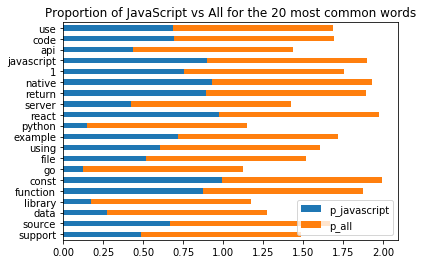

In [72]:
# figure out the percentage of javascript vs all
(word_counts
 .assign(p_javascript=word_counts.javascript / word_counts['all'],
         p_all=word_counts['all'] / word_counts['all'])
 .sort_values(by='all')
 [['p_javascript', 'p_all']]
 .tail(20)
 .sort_values('p_all')
 .plot.barh(stacked=True))

plt.title('Proportion of JavaScript vs All for the 20 most common words')

Creating a word cloud for all the languages, JavaScript, and Python.
- larger words are more frequent

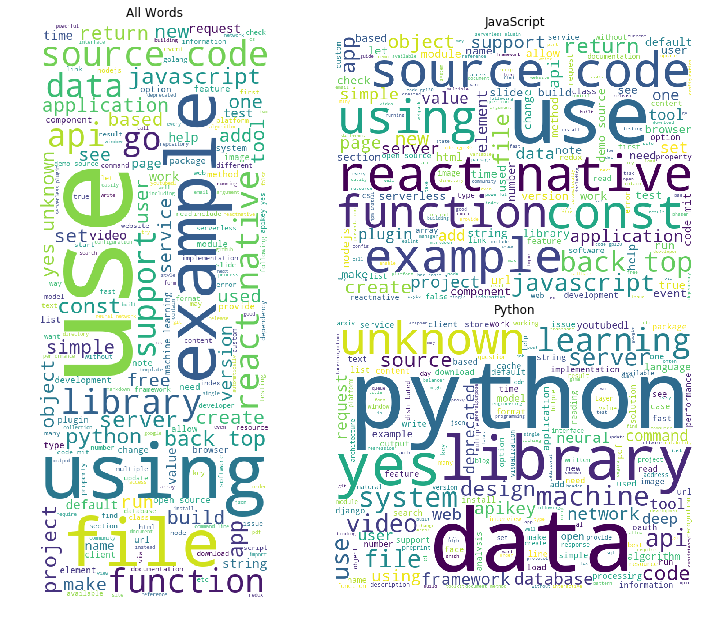

In [73]:
all_cloud = WordCloud(background_color='white', height=1000, width=400).generate(all_words)
javascript_cloud = WordCloud(background_color='white', height=600, width=800).generate(javascript_words)
python_cloud = WordCloud(background_color='white', height=600, width=800, collocations=False).generate(python_words)

plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(javascript_cloud)
axs[2].imshow(python_cloud)

axs[0].set_title('All Words')
axs[1].set_title('JavaScript')
axs[2].set_title('Python')

for ax in axs: ax.axis('off')

Exploring the top 20 bigrams in JavaScript words.

In [74]:
top_20_javascript_bigrams = (pd.Series(nltk.ngrams(javascript_words.split(), 2))
                      .value_counts()
                      .head(20))

top_20_javascript_bigrams.head()

(react, native)    692
(source, code)     680
(back, top)        528
(demo, source)     190
(code, mit)        162
dtype: int64

Visualizing the top 20 bigrams with a barplot.

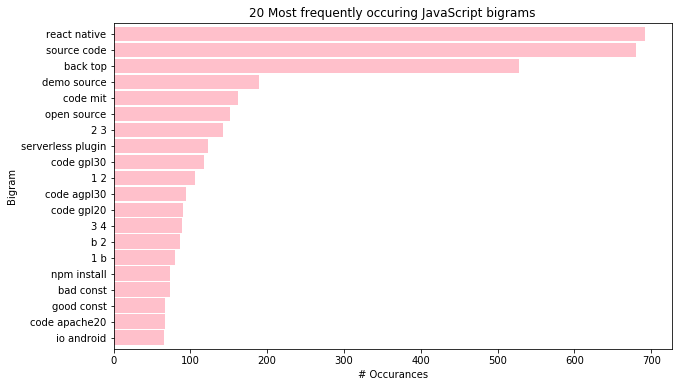

In [75]:
top_20_javascript_bigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring JavaScript bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_javascript_bigrams.reset_index().sort_values(by=0)['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

Visualizing the top 20 bigrams with a word cloud.

(-0.5, 799.5, 399.5, -0.5)

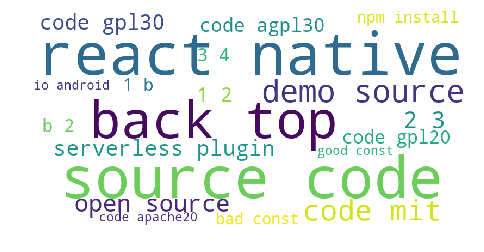

In [76]:
# We can supply our own values to be used to determine how big the words (or
# phrases) should be through the `generate_from_frequencies` method. The
# supplied values must be in the form of a dictionary where the keys are the
# words (phrases), and the values are numbers that correspond to the sizes.
#
# We'll convert our series to a dictionary, and convert the tuples that make up
# the index into a single string that holds each phrase.


data = {k[0] + ' ' + k[1]: v for k, v in top_20_javascript_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')

Exploring the top 20 trigrams in JavaScript words.

In [77]:
top_20_javascript_trigrams = (pd.Series(nltk.ngrams(javascript_words.split(), 3))
                      .value_counts()
                      .head(20))

top_20_javascript_trigrams.head()

(demo, source, code)      190
(source, code, mit)       159
(source, code, gpl30)     118
(source, code, agpl30)     94
(source, code, gpl20)      91
dtype: int64

Visualizing the top 20 trigrams with a barplot.

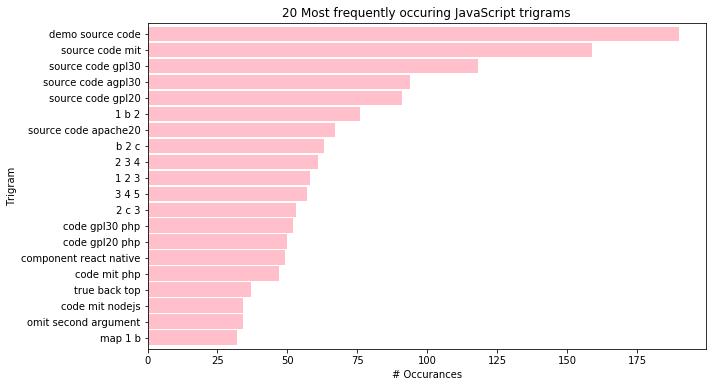

In [78]:
top_20_javascript_trigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring JavaScript trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_javascript_trigrams.reset_index().sort_values(by=0)['index'].\
apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

Visualizing the top 20 trigrams with a word cloud.

(-0.5, 799.5, 399.5, -0.5)

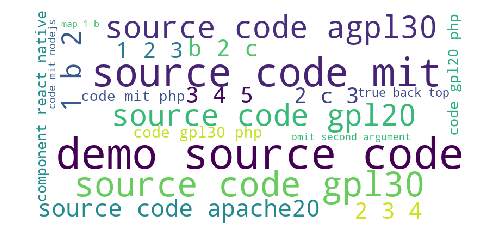

In [79]:
# We can supply our own values to be used to determine how big the words (or
# phrases) should be through the `generate_from_frequencies` method. The
# supplied values must be in the form of a dictionary where the keys are the
# words (phrases), and the values are numbers that correspond to the sizes.
#
# We'll convert our series to a dictionary, and convert the tuples that make up
# the index into a single string that holds each phrase.


data = {k[0] + ' ' + k[1] + ' ' + k[2]: v for k, v in top_20_javascript_trigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')

Visualizing the proportion of the 20 most common words.

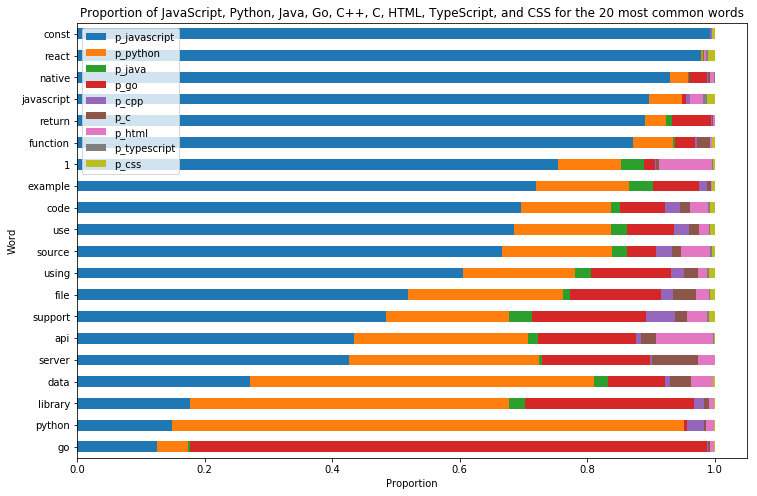

In [80]:
(word_counts
 .assign(p_javascript=word_counts.javascript / word_counts['all'],
         p_python=word_counts.python / word_counts['all'],
         p_java=word_counts.java / word_counts['all'],
         p_go=word_counts.go / word_counts['all'],
         p_cpp=word_counts.cpp / word_counts['all'],
         p_c=word_counts.c / word_counts['all'],
         p_html=word_counts.html / word_counts['all'],
         p_typescript=word_counts.typescript / word_counts['all'],
         p_css=word_counts.css / word_counts['all'])
 .sort_values(by='all')
 [['p_javascript', 'p_python', 'p_java', 'p_go', 'p_cpp', 'p_c', 'p_html', 'p_typescript', 'p_css']]
 .tail(20)
 .sort_values('p_javascript')
 .plot.barh(stacked=True, figsize=(12, 8)))

plt.ylabel('Word')
plt.xlabel('Proportion')
plt.title('Proportion of JavaScript, Python, Java, Go, C++, C, HTML, TypeScript, and CSS for the 20 most common words')
plt.show()

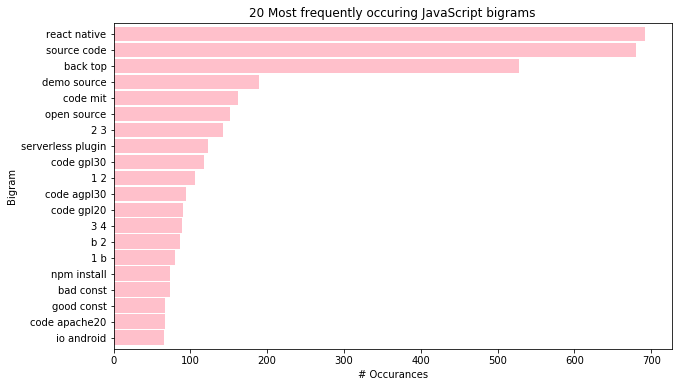

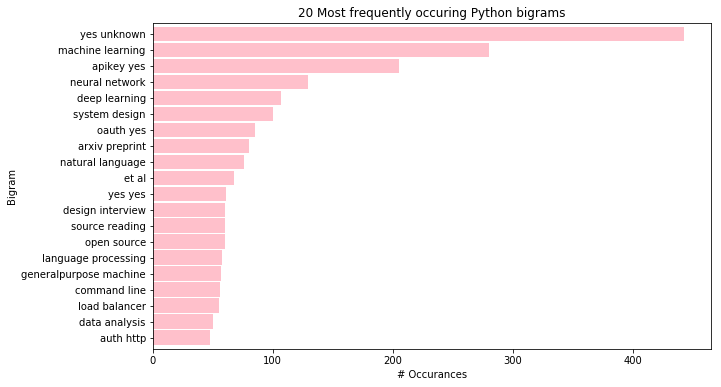

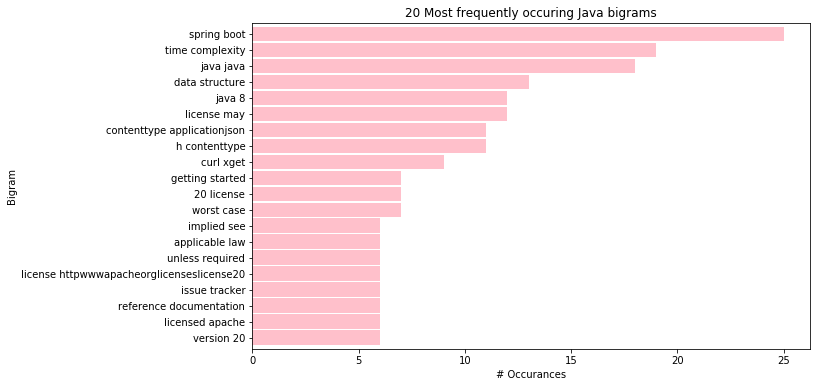

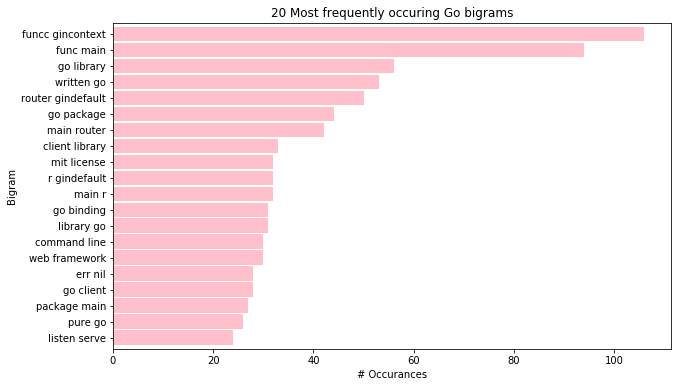

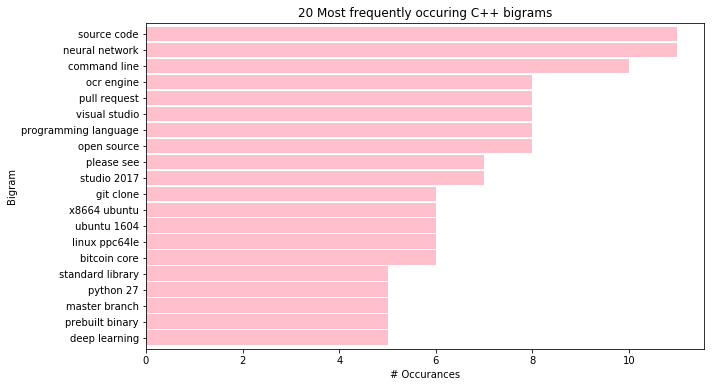

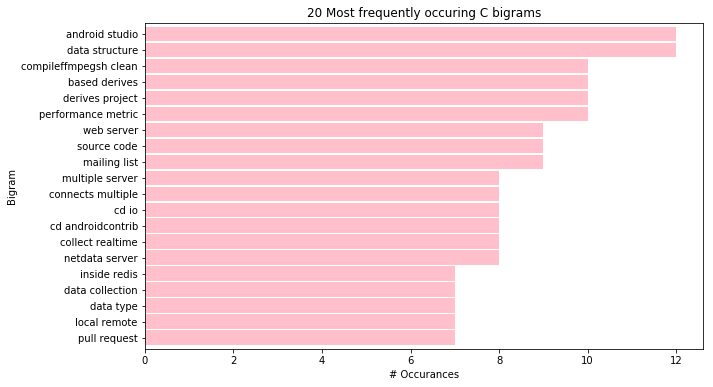

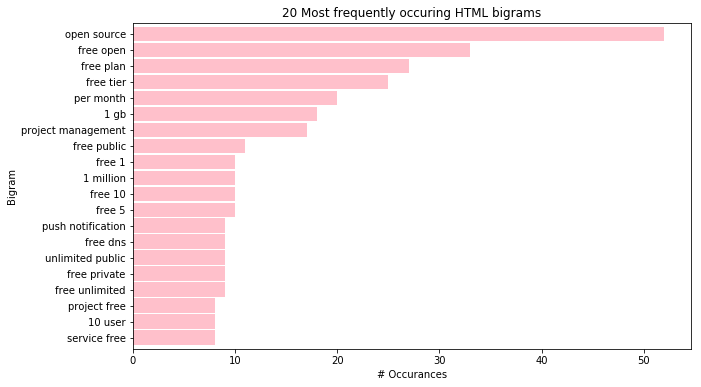

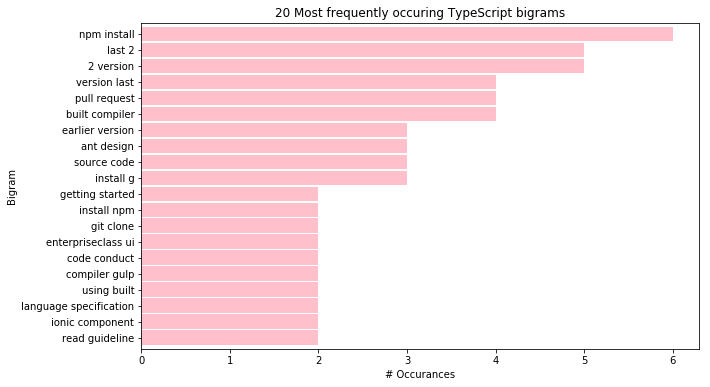

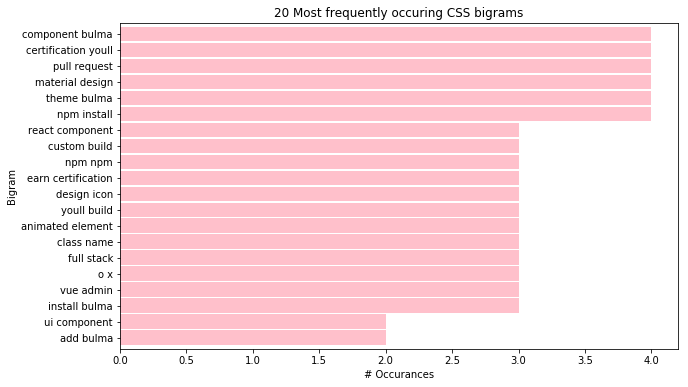

In [81]:
x=0
for i in [javascript_words, python_words, java_words, go_words, cpp_words, c_words, html_words, 
          typescript_words, css_words]:
    gram = (pd.Series(nltk.ngrams(i.split(), 2))
                          .value_counts()
                          .head(20))
    l = ['JavaScript', 'Python', 'Java', 'Go', 'C++', 'C', 'HTML', 'TypeScript', 'CSS']
    gram.head()

    gram.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))
    
    
    plt.title(f'20 Most frequently occuring {l[x]} bigrams')
    x += 1
    plt.ylabel('Bigram')
    plt.xlabel('# Occurances')

    # make the labels pretty
    ticks, _ = plt.yticks()
    labels = gram.reset_index().sort_values(by=0)['index'].apply(lambda t: t[0] + ' ' + t[1])
    _ = plt.yticks(ticks, labels)
    plt.show()

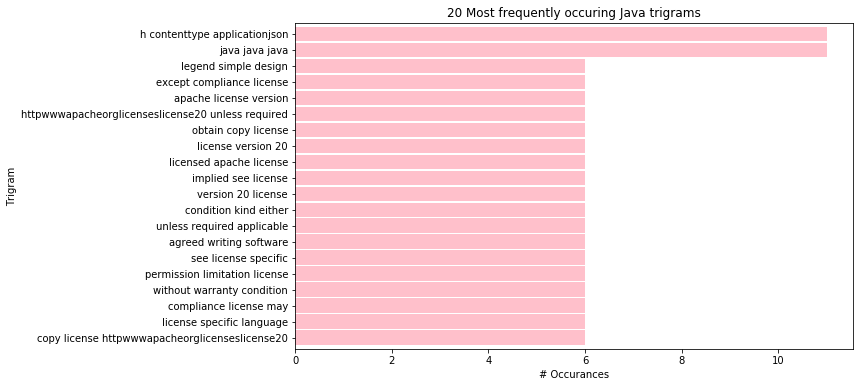

In [82]:
top_20_java_trigrams = (pd.Series(nltk.ngrams(java_words.split(), 3))
                      .value_counts()
                      .head(20))

top_20_java_trigrams.head()

top_20_java_trigrams.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring Java trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_java_trigrams.reset_index().sort_values(by=0)['index'].\
apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

# MODEL

In [83]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()

tfidfs = tfidf.fit_transform(df2.lemmatized)
tfidfs

# run at your own risk
nums = pd.DataFrame(tfidfs.todense(), columns=tfidf.get_feature_names())
nums.head()

,00,000,0000,00000,000000,00008080,00008080ping,00008787,0001,00042,...,zu,zulip,zurb,zweig,zxf,zydis,zynga,zypper,zyszys,zyszys98gmailcom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Trigrams
### Creating a column that contains the trigrams of each document.

In [84]:
def trigram_maker(string):
    list_of_words = string.split()
    trigram_list = []
    for a in range(len(list_of_words)):
        if a == len(list_of_words)-2:
            break
        trigram = list_of_words[a] + list_of_words[a+1] + list_of_words[a+2]
        trigram_list.append(trigram)
    return ' '.join(trigram_list)

In [85]:
df2['stemmed_trigrams'] = df2.stemmed.apply(trigram_maker)
df2.head()

,readme,language,lemmatized,stemmed,stemmed_trigrams
0,\n\n\n\n\n\nWelcome to freeCodeCamp.org's open...,JavaScript,welcome freecodecamporgs open source codebase ...,welcom freecodecamporg open sourc codebas curr...,welcomfreecodecamporgopen freecodecamporgopens...
2,\n\n\n\n\n\n\n\n\n\n\n\nSupporting Vue.js\nVue...,JavaScript,supporting vuejs vuejs mitlicensed open source...,support vuej vuej mitlicens open sourc project...,supportvuejvuej vuejvuejmitlicens vuejmitlicen...
3,"\n\n\n\n\n\nBootstrap\n\n Sleek, intuitive, a...",JavaScript,bootstrap sleek intuitive powerful frontend fr...,bootstrap sleek intuit power frontend framewor...,bootstrapsleekintuit sleekintuitpower intuitpo...
4,\nReact · \nReact is a JavaScript library f...,JavaScript,react react javascript library building user i...,react react javascript librari build user inte...,reactreactjavascript reactjavascriptlibrari ja...
5,\n\n\n\n\n\n\n\nDocumentation\n\n\n\n\n\n\n\n\...,C++,documentation tensorflow open source software ...,document tensorflow open sourc softwar librari...,documenttensorflowopen tensorflowopensourc ope...


In [86]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()

tfidfs = tfidf.fit_transform(df2.stemmed_trigrams)
tfidfs

# run at your own risk
nums = pd.DataFrame(tfidfs.todense(), columns=tfidf.get_feature_names())
nums.head()

,000,00000,000000timesimpli,00000clicksave,00000whitelistsection,00008080pingbrowsergo,00008080routerrun8080sampl,00008080routerrun8080serv,00008080rrun8080asciijson,00008080rrun8080custom,...,zuweichen,zweigachievhuman,zxf193resum,zxz,zydiassemblpower,zyngaenginblog,zypperinstaltype,zysziyongshengzhang,zyszys98gmailcomhehimcollabor,zz1
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Logistic Regression

In [87]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df2.stemmed_trigrams)
y = df2.language

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.4, random_state=123)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

lm = LogisticRegression(random_state=123, solver='newton-cg', multi_class='multinomial').fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

In [88]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 55.36%
---
Confusion Matrix
actual      C  C++  CSS  Go  HTML  Java  JavaScript  Python  TypeScript
predicted                                                              
C++         0    2    0   0     0     0           0       0           0
Go          0    0    0   2     0     0           0       0           0
Java        0    0    0   0     0     1           0       0           0
JavaScript  4    5    3   7     4    10          53      14           3
Python      0    0    0   0     0     0           0       4           0
---
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         4
         C++       1.00      0.29      0.44         7
         CSS       0.00      0.00      0.00         3
          Go       1.00      0.22      0.36         9
        HTML       0.00      0.00      0.00         4
        Java       1.00      0.09      0.17        11
  JavaScript       0.51      1.00      0.68        53
      Python       1.

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Decision Tree

In [89]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

clf = DecisionTreeClassifier(criterion='gini', max_depth=6, random_state=123)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_train)
y_pred_proba = clf.predict_proba(X_train)

print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))

print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of Decision Tree classifier on training set: 0.63
Accuracy of Decision Tree classifier on test set: 0.49


### Random Forest

In [90]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=2,
                            n_estimators=100,
                            max_depth=10, 
                            random_state=123)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_train)

print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))

Accuracy of random forest classifier on training set: 0.57


In [91]:
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(rf.score(X_test, y_test)))

Accuracy of random forest classifier on test set: 0.47


# Bag of Words
## Logistic Regression

In [92]:
from sklearn.feature_extraction.text import CountVectorizer

count_vec = CountVectorizer()
X = count_vec.fit_transform(df2.stemmed)
y = df2.language

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2, random_state=123)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

lm = LogisticRegression(random_state=123, solver='newton-cg', multi_class='multinomial').fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

In [93]:
nums = pd.DataFrame(X.todense(), columns=count_vec.get_feature_names())
nums.head()
# [nums > 0]

,00,000,0000,00000,000000,00008080,00008080ping,00008787,0001,00042,...,zu,zulip,zurb,zweig,zxf,zydi,zynga,zypper,zyszi,zyszys98gmailcom
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [94]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 100.00%
---
Confusion Matrix
actual      C  C++  CSS  Go  HTML  Java  JavaScript  Python  TypeScript
predicted                                                              
C           6    0    0   0     0     0           0       0           0
C++         0    9    0   0     0     0           0       0           0
CSS         0    0    4   0     0     0           0       0           0
Go          0    0    0  12     0     0           0       0           0
HTML        0    0    0   0     6     0           0       0           0
Java        0    0    0   0     0    14           0       0           0
JavaScript  0    0    0   0     0     0          70       0           0
Python      0    0    0   0     0     0           0      24           0
TypeScript  0    0    0   0     0     0           0       0           4
---
              precision    recall  f1-score   support

           C       1.00      1.00      1.00         6
         C++       1.00      1.00      1.00         9
  

In [95]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---')
print(classification_report(test.actual, test.predicted))

Accuracy: 52.63%
---
Confusion Matrix
actual      C  C++  CSS  Go  HTML  Java  JavaScript  Python  TypeScript
predicted                                                              
C++         0    0    0   0     0     0           0       1           0
Go          0    0    0   2     0     0           0       0           0
HTML        0    1    0   0     0     0           0       0           0
Java        0    0    0   0     0     3           1       0           0
JavaScript  1    1    0   1     1     0          12       2           1
Python      0    1    1   0     0     1           5       3           0
---
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         1
         C++       0.00      0.00      0.00         3
         CSS       0.00      0.00      0.00         1
          Go       1.00      0.67      0.80         3
        HTML       0.00      0.00      0.00         1
        Java       0.75      0.75      0.75         4
  J

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Decision Tree

In [96]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

clf = DecisionTreeClassifier(criterion='gini', max_depth=7, random_state=123)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_train)
y_pred_proba = clf.predict_proba(X_train)

print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))

print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of Decision Tree classifier on training set: 0.94
Accuracy of Decision Tree classifier on test set: 0.53


In [97]:
for i in range (1, 21):
    print(f'Max Depth of {i}')
    clf = DecisionTreeClassifier(criterion='gini', max_depth=i, random_state=123)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_train)
    y_pred_proba = clf.predict_proba(X_train)

    print('Accuracy of Decision Tree classifier on training set: {:.2f}'
         .format(clf.score(X_train, y_train)))

    print('Accuracy of Decision Tree classifier on test set: {:.2f}'
         .format(clf.score(X_test, y_test)))
    print('\n')

Max Depth of 1
Accuracy of Decision Tree classifier on training set: 0.52
Accuracy of Decision Tree classifier on test set: 0.39


Max Depth of 2
Accuracy of Decision Tree classifier on training set: 0.60
Accuracy of Decision Tree classifier on test set: 0.50


Max Depth of 3
Accuracy of Decision Tree classifier on training set: 0.69
Accuracy of Decision Tree classifier on test set: 0.55


Max Depth of 4
Accuracy of Decision Tree classifier on training set: 0.78
Accuracy of Decision Tree classifier on test set: 0.50


Max Depth of 5
Accuracy of Decision Tree classifier on training set: 0.84
Accuracy of Decision Tree classifier on test set: 0.53


Max Depth of 6
Accuracy of Decision Tree classifier on training set: 0.90
Accuracy of Decision Tree classifier on test set: 0.47


Max Depth of 7
Accuracy of Decision Tree classifier on training set: 0.94
Accuracy of Decision Tree classifier on test set: 0.53


Max Depth of 8
Accuracy of Decision Tree classifier on training set: 0.97
Accuracy 

### Random Forest

In [98]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='entropy',
                            min_samples_leaf=2,
                            n_estimators=100,
                            max_depth=10, 
                            random_state=123)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_train)

print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))

print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(rf.score(X_test, y_test)))

Accuracy of random forest classifier on training set: 0.86
Accuracy of random forest classifier on test set: 0.53


### KNN

In [99]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3, weights='uniform')
knn.fit(X_train, y_train)

y_pred = knn.predict(X_train)

print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))

print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of KNN classifier on training set: 0.81
Accuracy of KNN classifier on test set: 0.29


In [100]:
for i in range(1, 11):
    knn = KNeighborsClassifier(n_neighbors=i, weights='uniform')
    knn.fit(X_train, y_train)

    y_pred = knn.predict(X_train)
    print(f'{i} Neareast Neighbors')

    print('Accuracy of KNN classifier on training set: {:.2f}'
         .format(knn.score(X_train, y_train)))

    print('Accuracy of KNN classifier on test set: {:.2f}'
         .format(knn.score(X_test, y_test)))
    print('\n')

1 Neareast Neighbors
Accuracy of KNN classifier on training set: 1.00
Accuracy of KNN classifier on test set: 0.39


2 Neareast Neighbors
Accuracy of KNN classifier on training set: 0.91
Accuracy of KNN classifier on test set: 0.34


3 Neareast Neighbors
Accuracy of KNN classifier on training set: 0.81
Accuracy of KNN classifier on test set: 0.29


4 Neareast Neighbors
Accuracy of KNN classifier on training set: 0.63
Accuracy of KNN classifier on test set: 0.26


5 Neareast Neighbors
Accuracy of KNN classifier on training set: 0.64
Accuracy of KNN classifier on test set: 0.32


6 Neareast Neighbors
Accuracy of KNN classifier on training set: 0.64
Accuracy of KNN classifier on test set: 0.34


7 Neareast Neighbors
Accuracy of KNN classifier on training set: 0.64
Accuracy of KNN classifier on test set: 0.34


8 Neareast Neighbors
Accuracy of KNN classifier on training set: 0.64
Accuracy of KNN classifier on test set: 0.34


9 Neareast Neighbors
Accuracy of KNN classifier on training set:

# Truncated Singular Value Decomposition
with tf-idf

In [101]:
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

### Logistic Regression

In [102]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df2.stemmed)
y = df2.language

pca = TruncatedSVD(n_components=30)
X = pca.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.4, random_state=123)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

lm = LogisticRegression(random_state=123, solver='newton-cg', multi_class='multinomial').fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

In [103]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 60.71%
---
Confusion Matrix
actual      C  C++  CSS  Go  HTML  Java  JavaScript  Python  TypeScript
predicted                                                              
C++         0    2    0   0     0     0           0       0           0
Java        0    0    0   0     0     6           0       0           0
JavaScript  4    4    3   9     4     5          53      11           3
Python      0    1    0   0     0     0           0       7           0
---
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         4
         C++       1.00      0.29      0.44         7
         CSS       0.00      0.00      0.00         3
          Go       0.00      0.00      0.00         9
        HTML       0.00      0.00      0.00         4
        Java       1.00      0.55      0.71        11
  JavaScript       0.55      1.00      0.71        53
      Python       0.88      0.39      0.54        18
  TypeScript       0.00      0.00      

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [104]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---')
print(classification_report(test.actual, test.predicted))

Accuracy: 54.67%
---
Confusion Matrix
actual      C  C++  CSS  Go  HTML  Java  JavaScript  Python  TypeScript
predicted                                                              
Java        0    0    0   0     0     3           0       0           0
JavaScript  3    5    2   6     3     4          35       9           2
Python      0    0    0   0     0     0           0       3           0
---
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         3
         C++       0.00      0.00      0.00         5
         CSS       0.00      0.00      0.00         2
          Go       0.00      0.00      0.00         6
        HTML       0.00      0.00      0.00         3
        Java       1.00      0.43      0.60         7
  JavaScript       0.51      1.00      0.67        35
      Python       1.00      0.25      0.40        12
  TypeScript       0.00      0.00      0.00         2

   micro avg       0.55      0.55      0.55        75
  

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Decision Tree

In [105]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

clf = DecisionTreeClassifier(criterion='gini', max_depth=6, random_state=123)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_train)
y_pred_proba = clf.predict_proba(X_train)

print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))

print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of Decision Tree classifier on training set: 0.95
Accuracy of Decision Tree classifier on test set: 0.57


# Truncated Singular Value Decomp
with bag of words

In [106]:
count_vec = CountVectorizer()
X = count_vec.fit_transform(df2.stemmed)
y = df2.language

pca = TruncatedSVD(n_components=30)
X = pca.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.4, random_state=123)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

lm = LogisticRegression(random_state=123, solver='newton-cg', multi_class='multinomial').fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
# print('---')
# print('Confusion Matrix')
# print(pd.crosstab(train.predicted, train.actual))
# print('---')
# print(classification_report(train.actual, train.predicted))

print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
# print('---')
# print('Confusion Matrix')
# print(pd.crosstab(test.predicted, test.actual))
# print('---')
# print(classification_report(test.actual, test.predicted))

Accuracy: 94.64%
Accuracy: 56.00%


### Decision Tree

In [107]:
clf = DecisionTreeClassifier(criterion='gini', max_depth=6, random_state=123)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_train)
y_pred_proba = clf.predict_proba(X_train)

print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))

print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of Decision Tree classifier on training set: 0.91
Accuracy of Decision Tree classifier on test set: 0.40
